<a href="https://colab.research.google.com/github/ykato27/Deeper-Depth-Estimation/blob/main/%E5%8D%98%E7%9C%BC%E3%83%87%E3%83%97%E3%82%B9%E6%8E%A8%E5%AE%9A%E3%82%92%E7%94%A8%E3%81%84%E3%81%A6%E8%B7%9D%E9%9B%A2%E3%82%92%E8%A8%88%E6%B8%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 概要
- 単眼デプス推定モデルのMiDaS v2.1の推論結果に対し、
シンプルなキャリブレーションを行い、距離を測定する

    1. TensorFlow Hubの利用方法
    2. MiDaS v2.1を用いた単眼デプス推定
    3. 距離キャリブレーション

### TensorFlow Hub
- TensorFlow Hubはトレーニング済みの機械学習モデルのリポジトリ。
- 今回使用するMiDaSやBERT, Faster R-CNN, などのトレーニング済みモデルを数行のコードで再利用できる。
- [TensorFlow Hub](https://www.tensorflow.org/hub?hl=ja)

### MiDaS v2.1　で単眼デプス推定を実施

In [1]:
!pip install \
    tensorflow==2.7.0 \
    tensorflow-hub==0.12.0 \
    opencv-python==4.5.4.60 \
    matplotlib==3.2.2

     |████████████████████████████████| 60.3 MB 50 kB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
# サンプル画像をダウンロード
!wget "https://drive.google.com/uc?export=download&id=109k81EIZrzkji1yhxFuXodqhBje49g3X" -O sample.jpg

--2022-01-30 03:48:08--  https://drive.google.com/uc?export=download&id=109k81EIZrzkji1yhxFuXodqhBje49g3X
Resolving drive.google.com (drive.google.com)... 64.233.170.138, 64.233.170.100, 64.233.170.113, ...
Connecting to drive.google.com (drive.google.com)|64.233.170.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-bo-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/0k082560dvjh092hg1f3gm56augq2aud/1643514450000/18359579799548610926/*/109k81EIZrzkji1yhxFuXodqhBje49g3X?e=download [following]
--2022-01-30 03:48:09--  https://doc-08-bo-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/0k082560dvjh092hg1f3gm56augq2aud/1643514450000/18359579799548610926/*/109k81EIZrzkji1yhxFuXodqhBje49g3X?e=download
Resolving doc-08-bo-docs.googleusercontent.com (doc-08-bo-docs.googleusercontent.com)... 108.177.13.132, 2607:f8b0:400c:c09::84
Connecting to doc-08-bo-docs.googleusercontent.com (doc-08

In [3]:
import cv2

image = cv2.imread('sample.jpg')

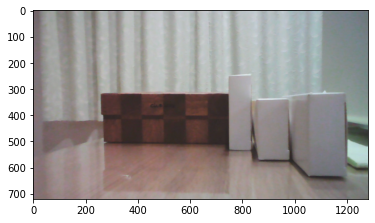

In [4]:
import matplotlib.pyplot as plt

rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_image)

MiDaSで推論

In [5]:
# TensorFlow HubからMiDaS v2.1 smallモデルをロード
import tensorflow_hub as hub

module = hub.load("https://tfhub.dev/intel/midas/v2_1_small/1", tags=['serve'])
model = module.signatures['serving_default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [6]:
import tensorflow as tf

# 画像読み込み
image = cv2.imread('sample.jpg')

# リサイズ
resize_image = cv2.resize(image, (256, 256))

# 正規化
resize_image = cv2.cvtColor(resize_image, cv2.COLOR_BGR2RGB) / 255.0

# 形状変更
resize_image = resize_image.transpose(2, 0, 1)
resize_image = resize_image.reshape(1, 3, 256, 256)

# tensor形式へ変換
tensor = tf.convert_to_tensor(resize_image, dtype=tf.float32)

In [7]:
# 推論
result = model(tensor)

In [8]:
# 推論結果を取り出し、余分な次元
import numpy as np

predict_result = result['default'].numpy()
predict_result = np.squeeze(predict_result)
print(predict_result.shape)

(256, 256)


推論結果を表示

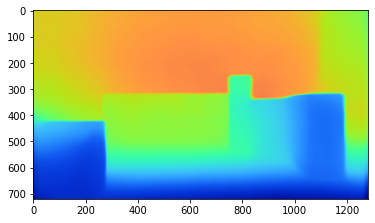

In [9]:
# オリジナル画像のサイズにリサイズ
predict_result = cv2.resize(predict_result, (image.shape[1], image.shape[0]))

# 最大値が255になるよう変換
depth_max = predict_result.max()
color_map = ((predict_result / depth_max) * 255).astype(np.uint8)

# カラーマップ画像へ変換
color_map = cv2.applyColorMap(color_map, cv2.COLORMAP_TURBO)

# 表示
plt.imshow(color_map)

### 最小二乗法を用いてキャリブレーションを実施

- MiDaSで取得できる距離の値は相対値
- 実際の距離を測る場合、実測値でキャリブレーションが必要
    - MiDaSに限らず、単眼デプス推定モデルは相対値であることが多い
- 今回はシンプルに最小二乗法を用いてキャリブレーションを実施

今回は例として、30cmの点を(400, 230)、25cmの点を(460, 230)の座標を用います。



In [10]:
print("25cm ->", predict_result[230][460])
print("30cm ->", predict_result[230][400])

25cm -> 137.14075
30cm -> 143.88396


絶対値のリストと相対値のリストを用意

In [11]:
relative_value_list = [137.14075, 143.88396]
absolute_value_list = [25, 30]

In [12]:
def linear_approximation(x, y):
    n = len(x)
    a = ((np.dot(x, y) - y.sum() * x.sum() / n) /
         ((x**2).sum() - x.sum()**2 / n))
    b = (y.sum() - a * x.sum()) / n
    return a, b

In [13]:
a, b = linear_approximation(
    np.array(relative_value_list),
    np.array(absolute_value_list),
)
print(a, b)

0.7414866213570184 -76.68803136786796


40cmの地点の座標で計算

In [14]:
absolute_value = (predict_result[230][330] * a) + b
print(absolute_value)

39.88385732995884


20cmの地点の座標で計算

In [15]:
absolute_value = (predict_result[230][540] * a) + b
print(absolute_value)

19.140108348920094


### 簡単なアプリとして仕上げる

In [16]:
import copy
import time

import cv2
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

import tkinter as tk
import tkinter.simpledialog as simpledialog


def mouse_callback(event, x, y, flags, param):
    # マウス座標、距離相対値、距離絶対値、キャリブレーション座標 保持用のグローバル変数
    global mouse_point
    global relative_value_list, absolute_value_list, calibration_p_list
    global depth_map

    mouse_point = [x, y]

    # マウス左クリック
    if event == cv2.EVENT_LBUTTONDOWN:
        # 実測値を入力
        input_data = simpledialog.askstring(
            "",
            "実測値(cm)を入力",
        )
        try:
            absolute_value = int(float(input_data))

            # 距離絶対値
            absolute_value_list.append(absolute_value)
            # 距離相対値
            relative_value_list.append(depth_map[y][x])
            # キャリブレーション座標
            calibration_p_list.append([x, y])
        except:
            # 数値以外
            pass


def run_inference(model, image):
    image_width, image_height = image.shape[1], image.shape[0]

    # リサイズ
    resize_image = cv2.resize(image, (256, 256))

    # 正規化
    resize_image = cv2.cvtColor(resize_image, cv2.COLOR_BGR2RGB) / 255.0

    # 形状変更
    resize_image = resize_image.transpose(2, 0, 1)
    resize_image = resize_image.reshape(1, 3, 256, 256)

    # tensor形式へ変換
    tensor = tf.convert_to_tensor(resize_image, dtype=tf.float32)

    # 推論
    result = model(tensor)

    # 余分な次元を削除し、入力画像のサイズへリサイズ
    result = result['default'].numpy()
    result = np.squeeze(result)
    result_depth_map = cv2.resize(result, (image_width, image_height))

    return result_depth_map


def linear_approximation(x, y):
    # 最小二乗法で1次関数(y = ax + b)の係数a, bを求める
    n = len(x)
    a = ((np.dot(x, y) - y.sum() * x.sum() / n) /
         ((x**2).sum() - x.sum()**2 / n))
    b = (y.sum() - a * x.sum()) / n
    return a, b


def draw_info(
    image,
    depth_map_,
    elapsed_time,
    mouse_point_,
    relative_value_list_,
    absolute_value_list_,
    calibration_p_list_,
    a=None,
    b=None,
):
    # 描画用フレーム作成
    rgb_frame = copy.deepcopy(image)
    depth_frame = copy.deepcopy(depth_map_)

    # 疑似カラー用の値レンジ調整
    depth_max = depth_frame.max()
    depth_frame = ((depth_frame / depth_max) * 255).astype(np.uint8)
    depth_frame = cv2.applyColorMap(depth_frame, cv2.COLORMAP_TURBO)

    # マウスポインタ上の推論値描画
    if mouse_point_ is not None:
        point_x = mouse_point_[0]
        point_y = mouse_point_[1]

        # キャリブレーション済の場合はcm表記で描画
        if a is not None and b is not None:
            display_d = "{0:.1f}".format(
                ((depth_map_[point_y][point_x] * a) + b)) + "cm"

            # RGB画像
            cv2.circle(rgb_frame, (point_x, point_y),
                       3, (0, 255, 0),
                       thickness=1)
            cv2.putText(rgb_frame, display_d, (point_x, point_y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2,
                        cv2.LINE_AA)

            # Depth画像
            cv2.circle(depth_frame, (point_x, point_y),
                       3, (255, 255, 255),
                       thickness=1)
            cv2.putText(depth_frame, display_d, (point_x, point_y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2,
                        cv2.LINE_AA)

    # キャリブレーションポイント描画
    for index, calibration_p in enumerate(calibration_p_list_):
        point_x = calibration_p[0]
        point_y = calibration_p[1]

        # RGB画像
        cv2.circle(rgb_frame, (point_x, point_y), 3, (0, 255, 0), thickness=1)
        cv2.putText(
            rgb_frame, "{0:.1f}".format(relative_value_list_[index]) + " : " +
            str(absolute_value_list_[index]) + "cm", (point_x, point_y - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1, cv2.LINE_AA)

        # Depth画像
        cv2.circle(depth_frame, (point_x, point_y),
                   3, (255, 255, 255),
                   thickness=1)
        cv2.putText(
            depth_frame, "{0:.1f}".format(relative_value_list_[index]) +
            " : " + str(absolute_value_list_[index]) + "cm",
            (point_x, point_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.4,
            (255, 255, 255), 1, cv2.LINE_AA)

    # 推論時間描画
    # RGB画像
    cv2.putText(rgb_frame,
                "Elapsed Time:" + '{:.1f}'.format(elapsed_time * 1000) + "ms",
                (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2,
                cv2.LINE_AA)
    # Depth画像
    cv2.putText(depth_frame,
                "Elapsed Time:" + '{:.1f}'.format(elapsed_time * 1000) + "ms",
                (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2,
                cv2.LINE_AA)

    return rgb_frame, depth_frame


if __name__ == "__main__":
    # マウス座標、距離相対値、距離絶対値、キャリブレーション座標 保持用のグローバル変数
    global mouse_point
    global relative_value_list, absolute_value_list, calibration_p_list
    global depth_map
    mouse_point = None
    relative_value_list, absolute_value_list, calibration_p_list = [], [], []
    depth_map = None

    # モデルロード
    tfhub_url = "https://tfhub.dev/intel/midas/v2_1_small/1"
    module = hub.load(tfhub_url, tags=['serve'])
    model = module.signatures['serving_default']

    # カメラ準備
    cap = cv2.VideoCapture(0)

    # Tkinter初期化
    root = tk.Tk()
    root.withdraw()

    # OpenCVウィンドウ初期化、マウス操作用のコールバックを登録
    rgb_window_name = 'rgb'
    cv2.namedWindow(rgb_window_name)
    cv2.setMouseCallback(rgb_window_name, mouse_callback)

    depth_window_name = 'depth'
    cv2.namedWindow(depth_window_name)
    cv2.setMouseCallback(depth_window_name, mouse_callback)

    while True:
        start_time = time.time()

        # カメラキャプチャ
        ret, frame = cap.read()
        if not ret:
            continue

        # Depth推定
        depth_map = run_inference(model, frame)

        # 相対距離と絶対距離を最小二乗法を用いて線形近似
        a, b = None, None
        if len(calibration_p_list) >= 2:
            a, b = linear_approximation(np.array(relative_value_list),
                                        np.array(absolute_value_list))

        elapsed_time = time.time() - start_time

        # 情報描画
        rgb_frame, depth_frame = draw_info(
            frame,
            depth_map,
            elapsed_time,
            mouse_point,
            relative_value_list,
            absolute_value_list,
            calibration_p_list,
            a,
            b,
        )

        cv2.imshow(rgb_window_name, rgb_frame)
        cv2.imshow(depth_window_name, depth_frame)
        key = cv2.waitKey(1)
        if key == 27:  # ESC
            break

    cap.release()
    cv2.destroyAllWindows()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


TclError: ignored